In [1]:
!pip install schnetpack
!pip install ase
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import LinearLocator, FormatStrFormatter
import pandas as pd
from  schnetpack import AtomsData
import schnetpack as spk
import schnetpack.train as trn
from ase.visualize import view
from ase.io import read
from ase.visualize.plot import plot_atoms
from ase.lattice.cubic import FaceCenteredCubic
qmH2O = '/content/drive/My Drive/Colab Notebooks/SchNet Files/qmH2O_3/'
SchNet_Files = '/content/drive/My Drive/Colab Notebooks/SchNet Files/'
from torch.optim import Adam
import torch

     |████████████████████████████████| 266kB 14.9MB/s 
     |████████████████████████████████| 317kB 26.4MB/s 
     |████████████████████████████████| 2.2MB 19.5MB/s 


In [ ]:
atoms = read('/content/drive/My Drive/Colab Notebooks/output_h2o_HF_ccpvdz_to_SchNet.xyz', index=':17636')
print(len(atoms))

In [ ]:
view(atoms[12852], viewer='x3d')

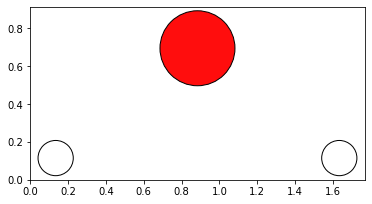

In [ ]:
fig, ax = plt.subplots()
plot_atoms(atoms[12852], ax, radii=0.3, rotation=('0x,0y,-90z'))

In [ ]:
print('Energy:', atoms[12852].info)

# parse properties as list of dictionaries
property_list = []
for at in atoms:
    energy = np.array([float(list(at.info.keys())[0])], dtype=np.float32)
    property_list.append(
        {'energy': energy}
    )
print(property_list[12852])
len(property_list)

Energy: {'-76.027388': True}
{'energy': array([-76.02739], dtype=float32)}


17636

In [2]:
#PyTorch dataset for atomistic data. The raw data is stored in the specified ASE database
new_dataset = AtomsData(SchNet_Files + 'new_dataset_H2O.db')


In [ ]:
#Se crea por primera vez en local con archivo.py
#new_dataset.add_systems(atoms, property_list)

In [3]:
train, val, test = spk.train_test_split(
        data=new_dataset,
        num_train=14108,
        num_val=3528,
        split_file= qmH2O +'split.npz',
    )

In [ ]:
train.get_properties(14107)
train.get_properties(12852)

/usr/local/lib/python3.6/dist-packages/schnetpack/data/atoms.py:327: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /pytorch/torch/csrc/utils/tensor_numpy.cpp:141.)
  properties[pname] = torch.FloatTensor(prop)
/usr/local/lib/python3.6/dist-packages/ase/atoms.py:972: VisibleDeprecationWarning: Use get_global_number_of_atoms() instead
  np.VisibleDeprecationWarning)


(Atoms(symbols='OH2', pbc=False),
 {'_atomic_numbers': tensor([8, 1, 1]), '_cell': tensor([[0., 0., 0.],
          [0., 0., 0.],
          [0., 0., 0.]]), '_cell_offset': tensor([[[0., 0., 0.],
           [0., 0., 0.]],
  
          [[0., 0., 0.],
           [0., 0., 0.]],
  
          [[0., 0., 0.],
           [0., 0., 0.]]]), '_neighbors': tensor([[1, 2],
          [0, 2],
          [0, 1]]), '_positions': tensor([[-0.0546,  0.0196,  0.0000],
          [ 0.2716,  0.3724,  0.0000],
          [ 0.5949, -0.6830,  0.0000]]), 'energy': tensor([-75.1008])})

In [ ]:
val.get_properties(3527)

/usr/local/lib/python3.6/dist-packages/ase/atoms.py:972: VisibleDeprecationWarning: Use get_global_number_of_atoms() instead
  np.VisibleDeprecationWarning)


(Atoms(symbols='OH2', pbc=False),
 {'_atomic_numbers': tensor([8, 1, 1]), '_cell': tensor([[0., 0., 0.],
          [0., 0., 0.],
          [0., 0., 0.]]), '_cell_offset': tensor([[[0., 0., 0.],
           [0., 0., 0.]],
  
          [[0., 0., 0.],
           [0., 0., 0.]],
  
          [[0., 0., 0.],
           [0., 0., 0.]]]), '_neighbors': tensor([[1, 2],
          [0, 2],
          [0, 1]]), '_positions': tensor([[-0.0503, -0.0053,  0.0000],
          [ 0.4353,  0.6392,  0.0000],
          [ 0.3637, -0.5547,  0.0000]]), 'energy': tensor([-75.8547])})

In [4]:
train_loader = spk.AtomsLoader(train, batch_size=100, shuffle=True)
val_loader = spk.AtomsLoader(val, batch_size=20)

atomrefs = new_dataset.get_atomref('energy')

In [5]:
means, stddevs = train_loader.get_statistics(
    property_names ='energy', single_atom_ref=atomrefs
)

/usr/local/lib/python3.6/dist-packages/schnetpack/data/atoms.py:327: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /pytorch/torch/csrc/utils/tensor_numpy.cpp:141.)
  properties[pname] = torch.FloatTensor(prop)
/usr/local/lib/python3.6/dist-packages/ase/atoms.py:972: VisibleDeprecationWarning: Use get_global_number_of_atoms() instead
  np.VisibleDeprecationWarning)


In [7]:
print('Mean atomization energy / atom:', means['energy'])
print('Std. dev. atomization energy / atom:', stddevs['energy'])

Mean atomization energy / atom: tensor([-75.7412])
Std. dev. atomization energy / atom: tensor([0.4302])


In [6]:
schnet = spk.representation.SchNet(
    n_atom_basis=10, n_filters=5, n_gaussians=20, n_interactions=5
)

output_E = spk.atomistic.Atomwise(n_in=10, atomref=atomrefs['energy'], property='energy',
                                   mean=means['energy'], stddev=stddevs['energy'])

model = spk.AtomisticModel(representation=schnet, output_modules=output_E)

In [9]:
optimizer = Adam(model.parameters(), lr=1e-2)
loss = trn.build_mse_loss(['energy'])
metrics = [spk.metrics.MeanAbsoluteError('energy')]
hooks = [
    trn.CSVHook(log_path=qmH2O, metrics=metrics),
    trn.ReduceLROnPlateauHook(
        optimizer,
        patience=3, factor=0.8, min_lr=1e-6,
        stop_after_min=True
    )
]
trainer = trn.Trainer(
    model_path=qmH2O,
    model=model,
    hooks=hooks,
    loss_fn=loss,
    optimizer=optimizer,
    train_loader=train_loader,
    validation_loader=val_loader,
)

In [10]:
device = "cuda" 
n_epochs = 1000
trainer.train(device=device, n_epochs=n_epochs)


/usr/local/lib/python3.6/dist-packages/ase/atoms.py:972: VisibleDeprecationWarning: Use get_global_number_of_atoms() instead
  np.VisibleDeprecationWarning)


Final train Loss: 0.000866
Final validation Loss: 0.000384
Final validation MAE: 0.013586


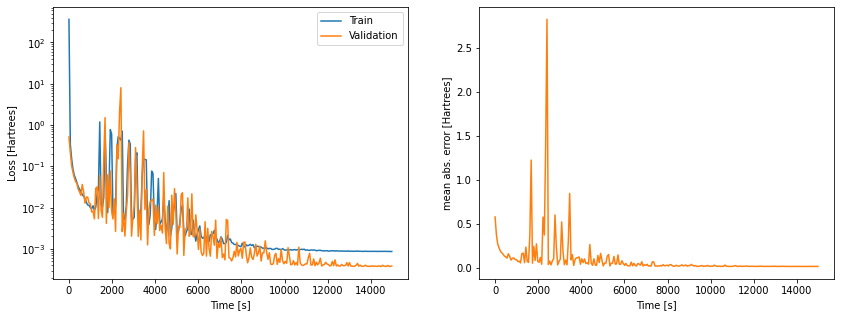

In [6]:
results = np.loadtxt(qmH2O + 'log.csv', skiprows=1, delimiter=',')

time = results[:,0]-results[0,0]
learning_rate = results[:,1]
train_loss = results[:,2]
val_loss = results[:,3]
val_mae = results[:,4]

print('Final train Loss:', np.round(train_loss[-1], 6))
print('Final validation Loss:', np.round(val_loss[-1], 6))
print('Final validation MAE:', np.round(val_mae[-1], 6))


plt.figure(figsize=(14,5))
plt.subplot(1,2,1)
plt.plot(time, train_loss, label='Train')
plt.plot(time, val_loss, label='Validation', color='tab:orange')
plt.yscale('log')
plt.ylabel('Loss [Hartrees]')
plt.xlabel('Time [s]')
plt.legend()
plt.subplot(1,2,2)
plt.plot(time, val_mae, label='Validation', color='tab:orange')
plt.ylabel('mean abs. error [Hartrees]')
plt.xlabel('Time [s]')
plt.show()

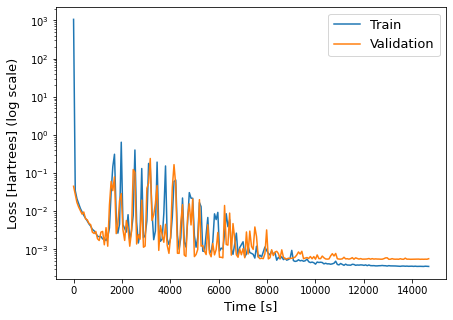

In [ ]:
plt.figure(figsize=(7,5))
plt.plot(time, train_loss, label='Train')
plt.plot(time, val_loss, label='Validation', color='tab:orange')
plt.yscale('log')
plt.ylabel('Loss [Hartrees] (log scale)', fontsize=13)
plt.xlabel('Time [s]', fontsize=13)
plt.legend(fontsize=13)

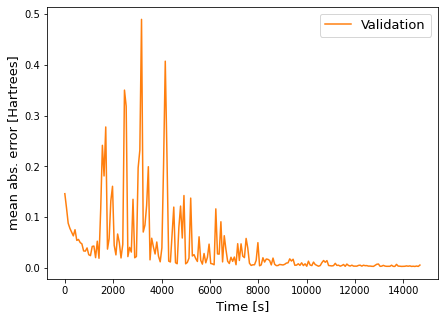

In [ ]:
plt.figure(figsize=(7,5))
plt.plot(time, val_mae, label='Validation', color='tab:orange')
plt.ylabel('mean abs. error [Hartrees]', fontsize=13)
plt.xlabel('Time [s]', fontsize=13)
plt.legend(fontsize=13)


In [ ]:
converter = spk.data.AtomsConverter(device=device)
at, props = val.get_properties(3527)
at
inputs = converter(at)
inputs
pred = model(inputs)
pred

/usr/local/lib/python3.6/dist-packages/ase/atoms.py:972: VisibleDeprecationWarning: Use get_global_number_of_atoms() instead
  np.VisibleDeprecationWarning)


{'energy': tensor([[-74.3922]], device='cuda:0', grad_fn=<SumBackward1>)}

In [ ]:
#dentro de Deep Graph Library
#Se incluye dgl.nn.pytorch.conv.cfconv
#Que son Torch modules for interaction blocks in SchNet
# CFConv in SchNet
'''
    SchNet is introduced in `SchNet: A continuous-filter convolutional neural network for
    modeling quantum interactions <https://arxiv.org/abs/1706.08566>`__.

    It combines node and edge features in message passing and updates node representations.
'''

device = 'cuda'
atomsdata0 = AtomsData(SchNet_Files + 'new_dataset_H2O_continua.db')
atomsdata0_loader = spk.AtomsLoader(atomsdata0, batch_size=1, shuffle=False)
best_model = torch.load(qmH2O + 'best_model')
err = 0
print(len(atomsdata0_loader))
data_df = pd.read_csv("/content/drive/My Drive/Colab Notebooks/output_plotdata_HF_ccpvdz_continua.csv")
data_df['energy_t']= np.nan
data_df['pred']= np.nan
for count, batch in enumerate(atomsdata0_loader):
 # move batch to GPU, if necessary
 batch = {k: v.to(device) for k, v in batch.items()}
 # apply model
 pred = best_model(batch)
 #print(count)
 #print(batch['energy'].detach().cpu().numpy()[0][0])
 data_df.loc[count,'penergy_t'] = batch['energy'].detach().cpu().numpy()[0][0]
 data_df.loc[count,'pred'] = pred['energy'].detach().cpu().numpy()[0][0]
 # calculate absolute error
 tmp = torch.sum(torch.abs(pred['energy']-batch['energy']))
 tmp = tmp.detach().cpu().numpy() # detach from graph & convert to numpy
 err += tmp
 # log progress
 #percent = '{:3.2f}'.format(count/len(train_loader)*100)
 #print('Progress:', percent+'%'+' '*(5-len(percent)), end="\r")
err /= len(atomsdata0)
err

8424


/usr/local/lib/python3.6/dist-packages/ase/atoms.py:972: VisibleDeprecationWarning: Use get_global_number_of_atoms() instead
  np.VisibleDeprecationWarning)


0.005033029337101399

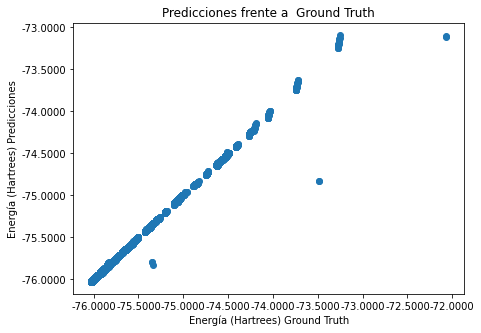

In [ ]:
fig, ax = plt.subplots(figsize=(7,5))
ax.scatter(data_df['energia'], data_df['pred'])
ax.set_title('Predicciones frente a  Ground Truth')
ax.set_xlabel('Energía (Hartrees) Ground Truth')
ax.set_ylabel('Energía (Hartrees) Predicciones')
ax.yaxis.set_major_formatter(FormatStrFormatter('%.4f'))
ax.xaxis.set_major_formatter(FormatStrFormatter('%.4f'))

plt.show()

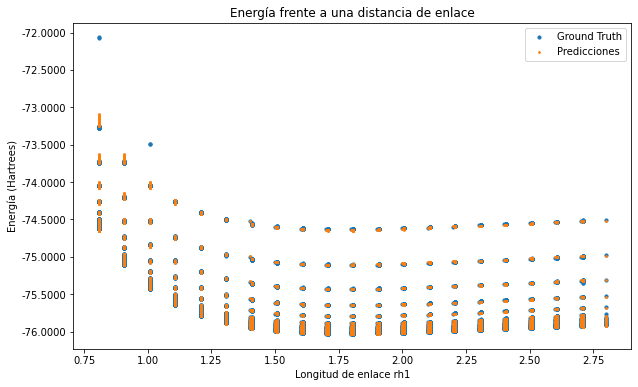

In [ ]:
fig, ax = plt.subplots(figsize=(10,6))

ax.scatter(data_df['rh1'], data_df['energia'], label='Ground Truth', s=10)
ax.scatter(data_df['rh1'], data_df['pred'], label='Predicciones', s=3)
ax.set_title('Energía frente a una distancia de enlace')
ax.set_xlabel('Longitud de enlace rh1')
ax.set_ylabel('Energía (Hartrees)')
ax.yaxis.set_major_formatter(FormatStrFormatter('%.4f'))
ax.legend()
index = 0


plt.show()

In [ ]:
print(data_df['pred'].idxmin()  )
indice_min_e =data_df['pred'].idxmin()
print(data_df['rh1'][indice_min_e])
print(data_df['rh2'][indice_min_e])
print(data_df['ang'][indice_min_e])
print(data_df['pred'][indice_min_e])

210
1.808
1.808
94.5
-76.03059387207031


In [ ]:
x_prueba = data_df[(data_df["rh1"]>1.70) & (data_df["rh1"]<1.8)  & (data_df["rh2"]>1.70) & (data_df["rh2"]<1.8)].copy()

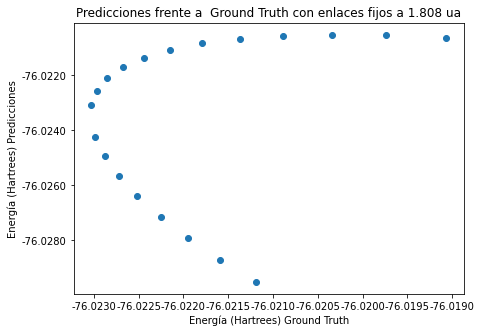

In [ ]:
fig, ax = plt.subplots(figsize=(7,5))
ax.scatter(x_prueba['energia'], x_prueba['pred'])
ax.set_title('Predicciones frente a  Ground Truth con enlaces fijos a 1.808 ua')
ax.set_xlabel('Energía (Hartrees) Ground Truth')
ax.set_ylabel('Energía (Hartrees) Predicciones')
ax.yaxis.set_major_formatter(FormatStrFormatter('%.4f'))
ax.xaxis.set_major_formatter(FormatStrFormatter('%.4f'))

plt.show()

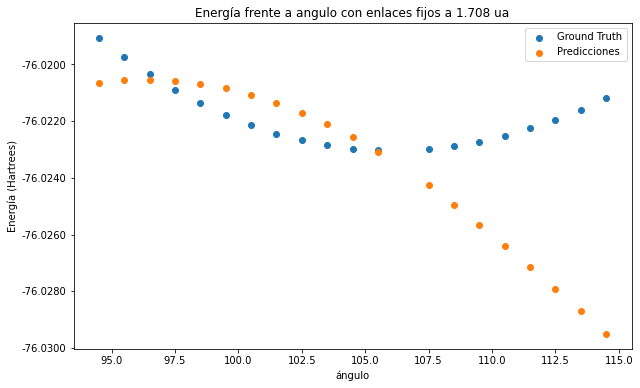

In [ ]:

fig, ax = plt.subplots(figsize=(10,6))

ax.scatter(x_prueba['ang'], x_prueba['energia'] , label='Ground Truth')
ax.scatter(x_prueba['ang'], x_prueba['pred'] , label='Predicciones')
ax.set_title('Energía frente a angulo con enlaces fijos a 1.708 ua')
ax.set_xlabel('ángulo')
ax.set_ylabel('Energía (Hartrees)')
ax.yaxis.set_major_formatter(FormatStrFormatter('%.4f'))
ax.legend()

plt.show()

In [ ]:
atomstest = AtomsData(SchNet_Files + 'new_dataset_H2O_test.db')
atomstest_loader = spk.AtomsLoader(atomstest, batch_size=1, shuffle=False)
best_model = torch.load(qmH2O + 'best_model')
err = 0
print(len(atomstest_loader))
data_df_test = pd.read_csv("/content/drive/My Drive/Colab Notebooks/output_plotdata_ccpvdz_HF_test.csv")
data_df_test['energy_t']= np.nan
data_df_test['pred']= np.nan
for count, batch in enumerate(atomstest_loader):
 # move batch to GPU, if necessary
 batch = {k: v.to(device) for k, v in batch.items()}
 # apply model
 pred = best_model(batch)
 #print(count)
 #print(batch['energy'].detach().cpu().numpy()[0][0])
 data_df_test.loc[count,'penergy_t'] = batch['energy'].detach().cpu().numpy()[0][0]
 data_df_test.loc[count,'pred'] = pred['energy'].detach().cpu().numpy()[0][0]
 # calculate absolute error
 tmp = torch.sum(torch.abs(pred['energy']-batch['energy']))
 tmp = tmp.detach().cpu().numpy() # detach from graph & convert to numpy
 err += tmp
 # log progress
 #percent = '{:3.2f}'.format(count/len(train_loader)*100)
 #print('Progress:', percent+'%'+' '*(5-len(percent)), end="\r")
err /= len(atomstest)
err

1577


/usr/local/lib/python3.6/dist-packages/ase/atoms.py:972: VisibleDeprecationWarning: Use get_global_number_of_atoms() instead
  np.VisibleDeprecationWarning)


0.003946172488060796

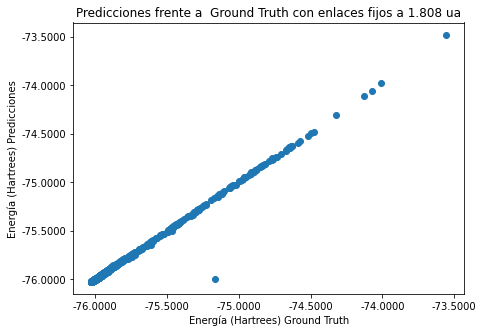

In [ ]:
fig, ax = plt.subplots(figsize=(7,5))
ax.scatter(data_df_test['energia'], data_df_test['pred'])
ax.set_title('Predicciones frente a  Ground Truth con enlaces fijos a 1.808 ua')
ax.set_xlabel('Energía (Hartrees) Ground Truth')
ax.set_ylabel('Energía (Hartrees) Predicciones')
ax.yaxis.set_major_formatter(FormatStrFormatter('%.4f'))
ax.xaxis.set_major_formatter(FormatStrFormatter('%.4f'))

plt.show()

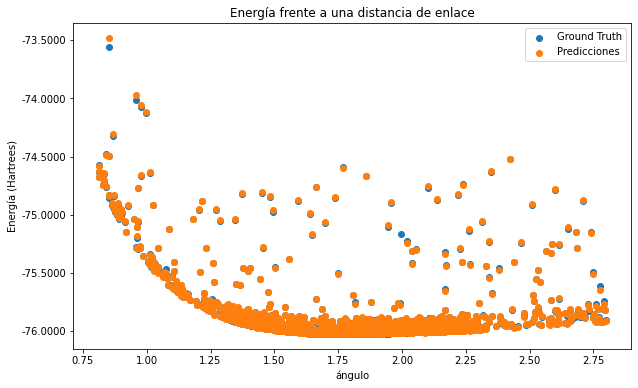

In [ ]:
fig, ax = plt.subplots(figsize=(10,6))

ax.scatter(data_df_test['rh1'], data_df_test['energia'], label='Ground Truth', s=10)
ax.scatter(data_df_test['rh1'], data_df_test['pred'], label='Predicciones', s=3)
ax.set_title('Energía frente a una distancia de enlace')
ax.set_xlabel('ángulo')
ax.set_ylabel('Energía (Hartrees)')
ax.yaxis.set_major_formatter(FormatStrFormatter('%.4f'))
ax.legend()

plt.show()

In [ ]:
print(data_df_test['pred'].idxmin()  )
indice_min_e =data_df_test['pred'].idxmin()
print(data_df_test['rh1'][indice_min_e])
print(data_df_test['rh2'][indice_min_e])
print(data_df_test['ang'][indice_min_e])
print(data_df_test['pred'][indice_min_e])

788
1.7308
1.7236
107.551
-76.02751922607422


In [ ]:
test_prueba = data_df_test[(data_df_test["rh1"]>1.70) & (data_df_test["rh1"]<1.8)  & (data_df_test["rh2"]>1.70) & (data_df_test["rh2"]<1.8)].copy()

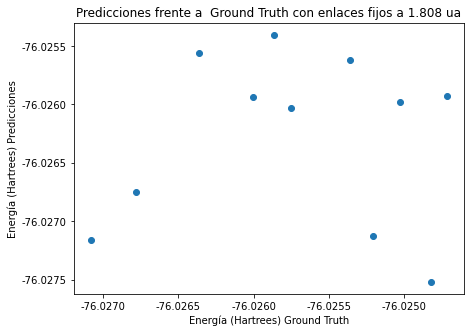

In [ ]:
fig, ax = plt.subplots(figsize=(7,5))
ax.scatter(test_prueba['energia'], test_prueba['pred'])
ax.set_title('Predicciones frente a  Ground Truth con enlaces fijos a 1.808 ua')
ax.set_xlabel('Energía (Hartrees) Ground Truth')
ax.set_ylabel('Energía (Hartrees) Predicciones')
ax.yaxis.set_major_formatter(FormatStrFormatter('%.4f'))
ax.xaxis.set_major_formatter(FormatStrFormatter('%.4f'))

plt.show()

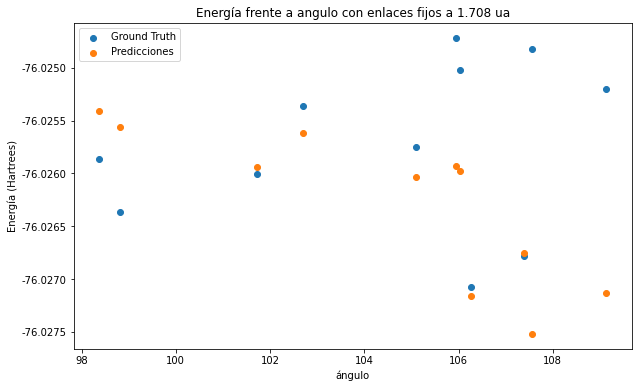

In [ ]:
fig, ax = plt.subplots(figsize=(10,6))

ax.scatter(test_prueba['ang'], test_prueba['energia'] , label='Ground Truth')
ax.scatter(test_prueba['ang'], test_prueba['pred'] , label='Predicciones')
ax.set_title('Energía frente a angulo con enlaces fijos a 1.708 ua')
ax.set_xlabel('ángulo')
ax.set_ylabel('Energía (Hartrees)')
ax.yaxis.set_major_formatter(FormatStrFormatter('%.4f'))
ax.legend()

plt.show()